In [109]:
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.interpolate as interpol

## Monday Week 1 (08/07/2024): Have to create a class for a bound mass profile
 - Look at https://github.com/LSSTDESC/CCL/blob/master/pyccl/halos/profiles/nfw.py as an example of the creation of a halo mass profile.
 - Python docs on classes: https://docs.python.org/3/tutorial/classes.html
 - Selected bits: 
   - the class inheritance mechanism allows multiple base classes
   - a derived class can override any methods of its base class or classes
   - a method can call the method of a base class with the same name

$\rho_X(r)\ = Ma ^{-3} f_X g_X(r)\$. 

- M = total halo mass
- $f_X$ = the fraction of that mass in gas species X
- $g(x)$ = the profile, which satisfies the normalisation $4\pi \int^{\infty}_0 dr\ r^2 g_X(r)\ = 1$
- a = the scale factor

$f_c + f_b + f_e + f_* = 1$ AND (assuming adiabaticity) $f_b + f_e + f_* = \bar{f}_b \equiv \frac{\Omega_b}{\Omega_M}$

----------------------------------------------------------------------------
In [paper](../Background-reading/XrayCrossCorrelations-1.pdf), see that:   
$\rho_x(r)\ = M f_x\ a^{-3} g_x(r)\ $    

$f_b(M) = []$   
$g_b(r)\ = \frac{1}{V_b} \left( \frac{log(1 + \frac{r}{r_s})}{\frac{r}{r_s}} \right)^{\frac{1}{\Gamma - 1}} $ , where $log \equiv ln$.    
$V_b \equiv 4\pi r_s^3 I_b(\frac{1}{\Gamma - 1}, 0)\ $   
$I_b(\gamma, q)\ = \int^{\infty}_0 dx\ x^2 \left( \frac{log(1+x)}{x} \right)^{\gamma} j_0(qx)\ $, with $ q = kr_s $ [in Fourier space].   
$\to I_b(\frac{1}{\Gamma - 1}, 0)\ = \int^{\infty}_0 dx\ x^2 \left( \frac{log(1+x)}{x} \right)^{\frac{1}{\Gamma - 1}} j_0(0)\  = \int^{\infty}_0 dx\ x^2 \left( \frac{log(1+x)}{x} \right)^{\frac{1}{\Gamma - 1}}$   
As $j_0 $ is a Besel function, & $j_0(0)\ = 1 $.

Therefore:   
$\rho_x(r)\ = \frac{M f_x\ }{4\pi r_s^3 a^{3}} \frac{1}{\int^{\infty}_0 dx\ x^2 \left( \frac{log(1+x)}{x} \right)^{\frac{1}{\Gamma - 1}}} \left( \frac{log(1 + \frac{r}{r_s})}{\frac{r}{r_s}} \right)^{\frac{1}{\Gamma - 1}} $ 

In [115]:
class boundGas_profile(ccl.halos.profiles.profile_base.HaloProfile): #(ccl.halos.Haloprofile):
    """Creating a class for the bound gas density profile
    where: """  # could put in the equations used

    def __init__(self, mass_def, r_s=1): # will change later, but can leave characteristic scale as ~ 1 Mpc for the moment
        self.r_s = r_s  # may need to add an rEj parameter into real & Fourier profiles below
        super(boundGas_profile, self).__init__(mass_def=mass_def)

        # General normalised profile (for q=0, over Gamma)
        self._normQ0 = None
        # Interpolator for dimensionless Fourier-space profile
        self._fourier_interp = None

      # ?  self.interpol_norm = interpol_
      #  if self.normQ0 = None: # gets the interpolated/interpolator re: normalised profile: q=0, over Gamma

#####
# To go in Fourier (or sth like this)
#    if self._fourier_interp is None:
 #           with UnlockInstance(self):
  #              self._fourier_interp = # should really be norm2/norm1 # self._norm_interpol2() # norm2 = with q & Gamma varying
#####
    
    def _shape(self, x, gam):
        gam_use = np.atleast_1d(gam)
        return (np.log(1+x)/x)**gam_use

    def _Vb_prefix(self, gamma, rS=1):
        rS_use = np.atleast_1d(rS)
        gamma_use = np.atleast_1d(gamma)

        def innerInt(x, gam=1/(gamma_use-1)): #(a, gam=1/(gamma_use-1), b=1, c=1):
            return x**2 * self._shape(x, gam)   
            # eqn = (1/c) * (a**2) * (np.log(1 + a/b)/(a/b))**gam
        
        vB1 = integrate.quad(innerInt, 0, np.inf)  # (func, a, b[, args, full_output, ...])
        vB2 = 4*np.pi*(rS_use**3)*vB1[0]
        return vB2

    def _norm_interpol1(self):  # interpol1 for q = 0
        gamma_list = np.linspace(1.01, 10, 1E3) # start, stop, number of evenly spaced samples

        for 
            integrate.quad(self._Vb_prefix, , , (args = rS))
        #interpol.RegularGridInterpolator() # (points, values, ...

        return
        
    def _real(self, r, M, gamma, r_s=1,
              scale_a=1, f=1): # set the default pars for scale factor a & fraction of total mass f
        r_use = np.atleast_1d(r) # need them to be functional arrays
        M_use = np.atleast_1d(M)
        rS_use = np.atleast_1d(r_s)
        gamma_use = np.atleast_1d(gamma)

        if self._normQ0 is None: # none instead of == here
            with UnlockInstance(self):
                self._normQ0 = self._norm_interpol1() 
            # Then need to implement normQ0 *into* the real function
            
# Returns: float or array_like: halo profile. Shape of the output = `(N_M, N_r)` where `N_r` & `N_m` = the sizes of `r` & `M` respectively.
        vB_prefix = self._Vb_prefix(gamma_use, rS_use)[0]
        prefix = M_use * f * (1/scale_a**3) * (1/vB_prefix)

        x = r_use[None, :] / rS_use[:, None]
        prof = prefix[:, None] * self._shape(x, 1/(gamma_use-1)) # default par of gam = 1/(gamma_use-1) #innerInt(x)

        if np.ndim(r) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
                                                          
        return prof

#### THEN DO FOURIER EQN!!!
    def _fourier(self, k, M, r_s, gamma,
                 a=1, f=1):
        k_use = np.atleast_1d(k)
        M_use = np.atleast_1d(M)
        rS_use = np.atleast_1d(r_s)

        prefix = M_use * f / a**3
        x = k_use[None, :] * rEj_use[:, None]
        # delete: prof = np.exp(-(1/2)*(r_use[None, :]/r_ej[:, None])**2)
        prof = prefix[:, None] * np.exp(-(x**2)/2)

        #prof = M_use * f * np.exp(-(1/2)*(k_use*r_ej)**2)/(a**3)

        if np.ndim(k) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)

        return prof
    

Characteristic scale $r_s$ should be ~ 1 Mpc (so leave as = 1), and gamma $\Gamma$ (which has no real physical significance, just a fitting number) should be around ~ 1.1-1.2 (but when doing normalisation interpolator, should do for $\Gamma \in [1.01,10]$ ).

In [117]:
# working with z = 0 (today) ; therefore a = 1
# use a mass definition with Delta = 200
hmd_200c = ccl.halos.MassDef200c
bd_rsTrial = 1
trial_boundProf = boundGas_profile(hmd_200c)#, bd_rsTrial) # (mass_def, r_s) (r_s = the characteristic scale)

In [119]:
trial_r = np.geomspace(1E-2,1E8,100000) # geomspace is like linspace, but evenly spaces on a logscale
trial_M = np.array([5E12,2E13, 1E14])
trial_gamma = 1.1 # np.array([2,3,4])


In [121]:
profTrial_real = trial_boundProf._real(trial_r, trial_M, trial_gamma, bd_rsTrial) # _real(self, r, M, gamma, r_s=1, scale_a=1, f=1)
profTrial_real

array([[7.20643922e+12, 7.20635693e+12, 7.20627462e+12, ...,
        3.42210804e-55, 3.41466415e-55, 3.40723645e-55],
       [2.88257569e+13, 2.88254277e+13, 2.88250985e+13, ...,
        1.36884322e-54, 1.36586566e-54, 1.36289458e-54],
       [1.44128784e+14, 1.44127139e+14, 1.44125492e+14, ...,
        6.84421608e-54, 6.82932830e-54, 6.81447289e-54]])

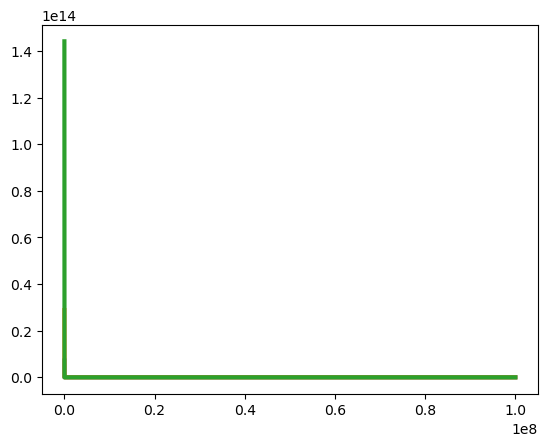

In [123]:
i=0
for j in trial_M:
    plt.plot(trial_r, profTrial_real[i], lw=3, zorder = i)
    i+=1

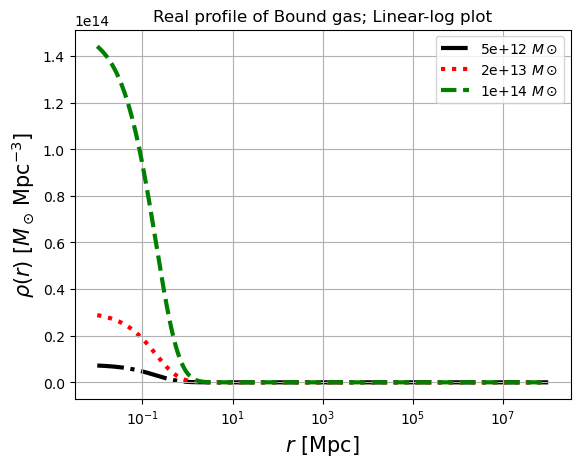

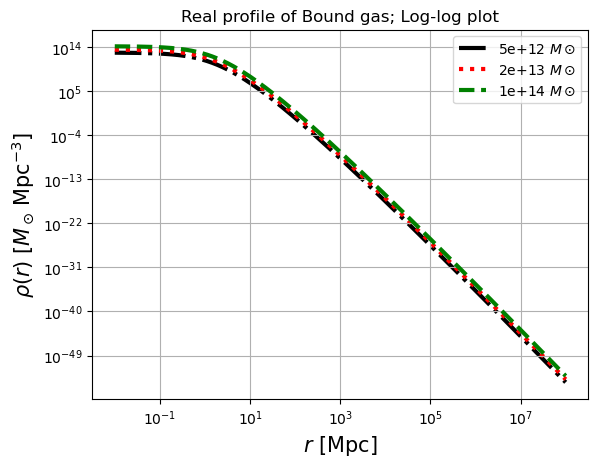

In [125]:
colours = ['k-.', 'r:', 'g--']
i = 0
for j in trial_M:
    plt.plot(trial_r, profTrial_real[i],
         colours[i], lw=3, zorder = i, label=f'{trial_M[i]:.1g} $M \\odot $')
    i+=1
plt.ylabel(r'$\rho(r)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$r\,\,[{\rm Mpc}]$', fontsize=15);
plt.title('Real profile of Bound gas; Linear-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');
#plt.xlim(1e-2,1e5);
#plt.ylim(1e-2,1e5);

plt.figure()
i = 0
for j in trial_M:
    plt.plot(trial_r, profTrial_real[i],
         colours[i], lw=3, zorder = i, label=f'{trial_M[i]:.1g} $M \\odot $')
    i+=1
plt.ylabel(r'$\rho(r)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$r\,\,[{\rm Mpc}]$', fontsize=15);
plt.title('Real profile of Bound gas; Log-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');
plt.yscale('log');
#plt.xlim(1e-2,1e5);
#plt.ylim(1e-2,1e5);

# Fourier profile for the bound gas to be done ()

In [251]:
trial_k = np.geomspace(1E-20,1E2,100000)
trial_M = np.array([5E12,2E13, 1E14])
profTrial_fourier = trial_bdProf._fourier(trial_k, trial_M,  bd_rsTrial) # , 
profTrial_fourier

array([[5.e+12, 5.e+12, 5.e+12, ..., 0.e+00, 0.e+00, 0.e+00],
       [2.e+13, 2.e+13, 2.e+13, ..., 0.e+00, 0.e+00, 0.e+00],
       [1.e+14, 1.e+14, 1.e+14, ..., 0.e+00, 0.e+00, 0.e+00]])

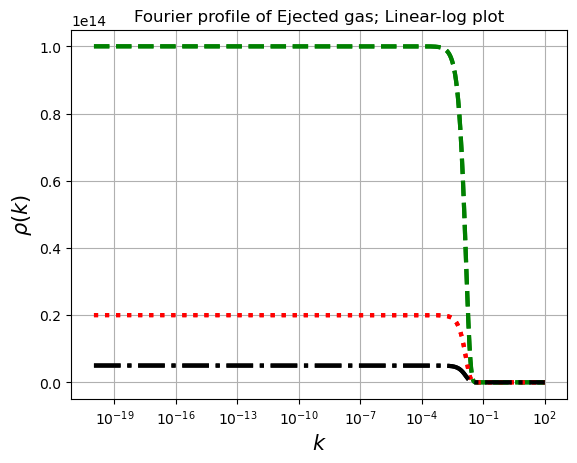

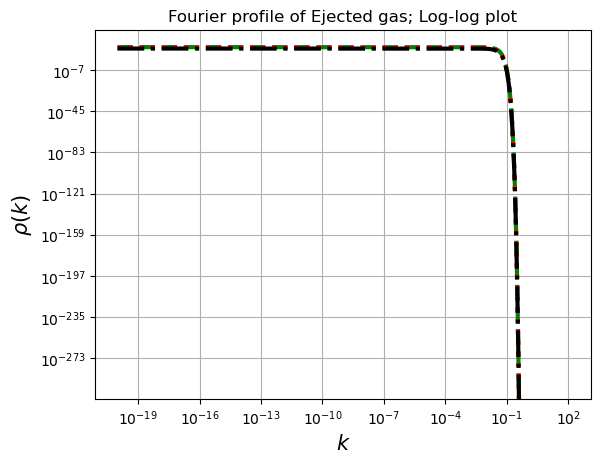

In [277]:
#### colours = ['k-.', 'r:', 'g--']
i = 0
for j in trial_M:
    plt.plot(trial_k, profTrial_fourier[i],
         colours[i], lw=3)
    i+=1
# plt.ylabel(r'$\rho(k)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
# plt.xlabel(r'$k\,\,[{\rm Mpc}]$', fontsize=15);
plt.xscale('log');

i = 0
for j in trial_M:
    plt.plot(trial_k, profTrial_fourier[i],
         colours[i], lw=3, zorder = (10-i))
    i+=1
plt.ylabel(r'$\rho(k)\, \,[M_\odot\,{\rm Mpc}^{-3}]$', 
           fontsize=15)
plt.xlabel(r'$k\, \,[{\rm Mpc^{-1}}]$', 
           fontsize=15);
plt.title('Fourier profile of Bound gas; Linear-log plot')
plt.grid(True)
plt.xscale('log');
plt.xlim(1e-5,1e2);
#plt.ylim(1e-5,1e2);

plt.figure()
i = 0
for j in trial_M:
    plt.plot(trial_k, profTrial_fourier[i],
         colours[i], lw=3, zorder = (10-i))
    i+=1
plt.ylabel(r'$\rho(k)\, \,[M_\odot\,{\rm Mpc}^{-3}]$', 
           fontsize=15)
plt.xlabel(r'$k\, \,[{\rm Mpc^{-1}}]$', 
           fontsize=15);
plt.title('Fourier profile of Bound gas; Log-log plot')
plt.grid(True)
plt.xscale('log');
plt.yscale('log');
plt.xlim(1e-5,1e2);
#plt.ylim(1e-5,1e2);